# 집값 예측 경진대회

`-` 참고 코드 : [동화책님의 GBR + RF + RG + NGB + 파생변수 (public : 0.09509)](https://dacon.io/competitions/official/235869/codeshare/4304?page=1&dtype=recent)

## 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_theme()
sns.set(rc = {'figure.figsize':(12, 8)})

In [3]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
df.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


|컬럼명 |세부사항 |
|:-:|:-:|
|id | 데이터 고유 id|
|Overall Qual | 전반적 재료와 마감 품질|
|Year Built | 완공 연도|
|Year Remod/Add | 리모델링 연도|
|Exter Qual | 외관 재료 품질|
|Bsmt Qual |지하실 높이|
|Total Bsmt SF| 지하실 면적| 
|1st Flr SF | 1층 면적 |
|Gr Liv Area | 지상층 생활 면적|
|Full Bath | 지상층 화장실 개수| 
|Kitchen Qual | 부엌 품질 |
|Garage Yr Blt | 차고 완공 연도|
|Garage Cars| 차고 자리 개수|
|Garage Area| 차고 면적 |
|target | 집값(달러 단위)|

In [5]:
df.isnull().values.any()

False

In [6]:
test.isnull().values.any()

False

In [7]:
df.shape

(1350, 15)

`-` 결측치는 없으며 행은 1350개, 열은 14개입니다

In [8]:
## 기초 통계량을 살펴봅니다
df.describe()

,id,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
count,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,675.500000,6.208889,1513.542222,1.870370,502.014815,1082.644444,1167.474074,1.560741,1972.987407,1985.099259,1978.471852,186406.312593
std,389.855743,1.338015,487.523239,0.652483,191.389956,384.067713,375.061407,0.551646,29.307257,20.153244,25.377278,78435.424758
min,1.000000,2.000000,480.000000,1.000000,100.000000,105.000000,480.000000,0.000000,1880.000000,1950.000000,1900.000000,12789.000000
25%,338.250000,5.000000,1144.000000,1.000000,368.000000,816.000000,886.250000,1.000000,1955.000000,1968.000000,1961.000000,135000.000000
50%,675.500000,6.000000,1445.500000,2.000000,484.000000,1009.000000,1092.500000,2.000000,1976.000000,1993.000000,1978.500000,165375.000000
75%,1012.750000,7.000000,1774.500000,2.000000,588.000000,1309.500000,1396.500000,2.000000,2002.000000,2004.000000,2002.000000,217875.000000
max,1350.000000,10.000000,4476.000000,5.000000,1488.000000,2660.000000,2898.000000,4.000000,2010.000000,2010.000000,2207.000000,745000.000000


`-` 연속형 변수들의 평균이 중앙값보다 큰 것으로 보아 오른쪽으로 꼬리가 긴 분포인 듯 합니다

`-` Garage Yr Blt의 최대값이 2207인 점을 제외하면 다른 문제는 없어보입니다

`-` 우선 분석의 편의를 위해 컬럼명을 바꾸겠습니다

In [9]:
## 공백과 슬래쉬를 _로 대체 1st을 First로 바꾼다
df.rename(columns = dict(zip(df.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'Fir') for column in df.columns])), inplace = True) 
test.rename(columns = dict(zip(test.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'Fir') for column in test.columns])), inplace = True) 

In [10]:
## id 컬럼은 드랍
df.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

`-` 좋은 등급이 큰 값을 가지도록 하기위해 라벨인코딩을 정의합니다

In [11]:
def label_encoding(data):
    grade_label = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] ## 퀄리티가 좋은 순서는 Ex(Excellent) >  Gd(Good) > TA(Average/Typical) > Fa(Fair) > Po(Poor)
    
    for grade, label in enumerate(grade_label):
        if data == label:
            return grade

In [12]:
for col in df.columns[df.dtypes == 'object']:
    df[col] = df[col].apply(lambda x: label_encoding(x))
    test[col] = test[col].apply(lambda x: label_encoding(x))

## 간단한 EDA

### 상관계수

<AxesSubplot:>

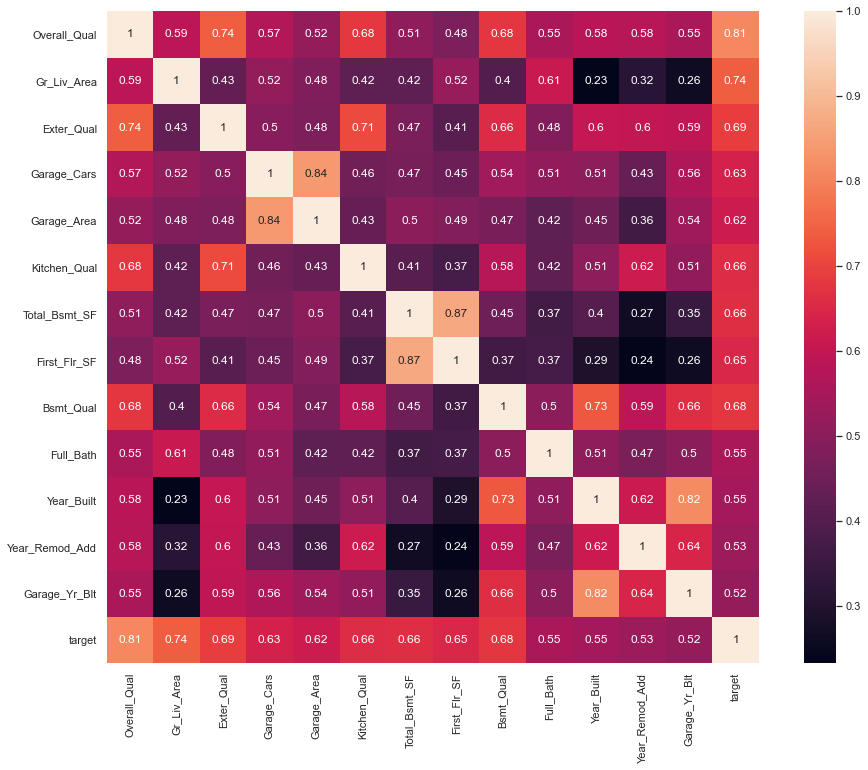

In [13]:
plt.figure(figsize = (16, 12))
corr_matrix = df.corr(method = 'pearson') # 상관관계 행렬
sns.heatmap(corr_matrix, annot = True, square = True)

`-` Overall_Qual과 Gr_Liv_Area가 target과의 상관관계가 강합니다

### target의 분포

<AxesSubplot:xlabel='target'>

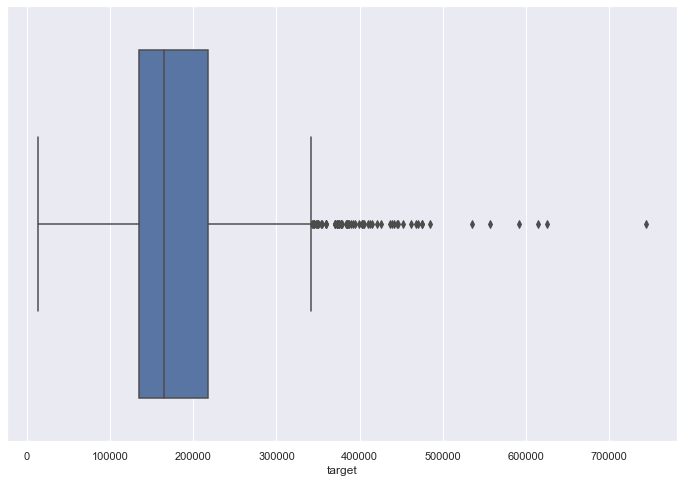

In [14]:
sns.boxplot(x = 'target', data = df)

<AxesSubplot:xlabel='Overall_Qual', ylabel='target'>

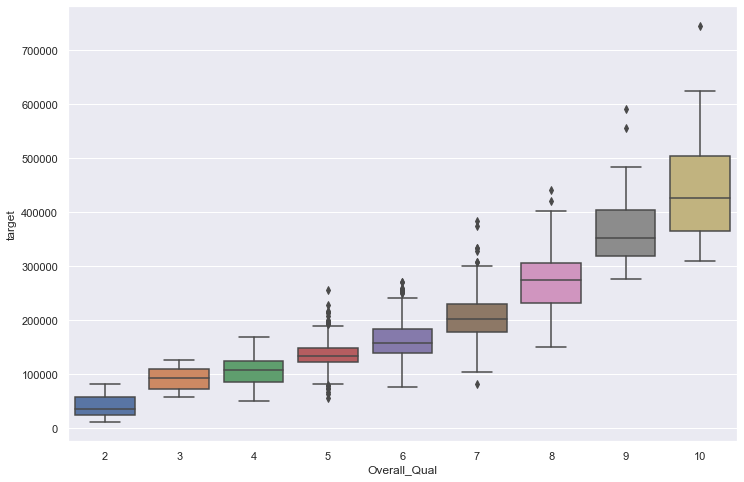

In [15]:
sns.boxplot(y = 'target', x = 'Overall_Qual', data = df)

## 이상점 제거

`-` 이상점이 모델 학습에서 악영향을 끼칠 수 있기에 제거하려고 합니다

`-` 간단하게 target만을 고려하여 이상점을 제거할 수 있겠지만(35만 달러를 넘어가면 이상점이네요)

`-` 그렇게 하면 당연하게도 너무 비싸거나 싼 값만이 이상점이 됩니다

`-` 집값이 형성되는데 복합적인 이유가 있겠지만 편의상 target과의 상관계수가 가장 높은 Overall_Qual을 기준으로 삼겠습니다

`-` 예컨대 Overall_Qual이 9나 10인 경우 높은 등급이기 때문에 집이 비싼 가격대에서 형성되지만 이상점이라고 할 수는 없습니다(하지만 전체 target을 기준으로 이상점을 없앤다면 대부분이 제거되겠죠) 

`-` Overall_Qual이 10인 경우 target의 박스플랏을 보면 이상점이 1개 존재합니다

`-` 같은 Overall_Qual 값을 가지더라도 다른 이유(집이 더 넓다 등등)로 인해 집값이 비쌀 수 있지만 이런 경우는 보편적인 상황이 아니라고 생각하여 이상점으로 취급해 제거하겠습니다

- 정리하면 아래와 같습니다

`-` 집값만 고려하여 이상점을 제거하자!! ---> 너무 싸거나 비싼 집값만 제거된다

`-` Overall_Qual이 4인데 집값이 30만 달러라고 할 때 Overall_Qual을 기준으로 보면 이상점이지만 전체 target을 기준으로 보면 35만 달러보다 작기에 이상점이 아니다

`-` `이상점` : `"Overall_Qual이 4이긴 한데요... 집의 면적이 넓어서 30만 달러에요! 그러니깐 없애지 말아주세요"` --->

`-` ---> 이런 경우는 편의상 보편적이지 않으니 제거한다, 변동성만 커져서 문제가 될 수 있다

`-` 그런데 target이 오른쪽으로 꼬리가 긴 분포여서 로그 변환한 값을 기준으로 이상점을 제거합니다

<AxesSubplot:xlabel='Overall_Qual', ylabel='target'>

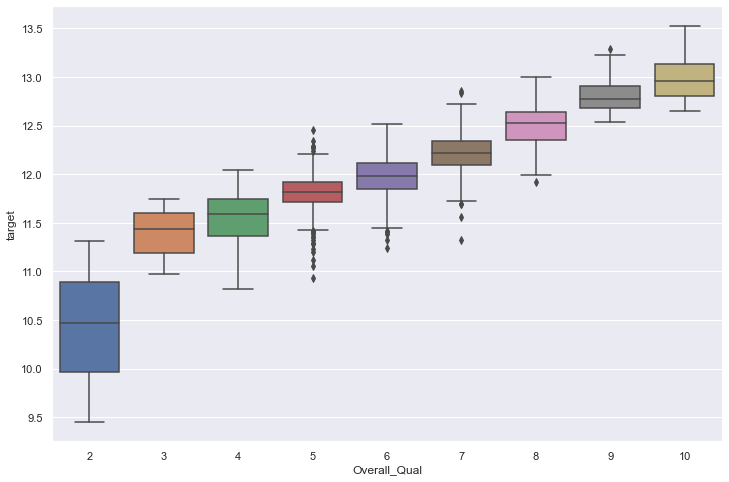

In [16]:
sns.boxplot(y = np.log(df['target']), x = 'Overall_Qual', data = df)

In [17]:
def remove_outlier(df_, type_ = 'default'):
    df = df_.copy()
    if type_ == 'log':
        df['target'] = np.log(df['target'])
        
    Q1 = df['target'].quantile(0.25)
    Q3 = df['target'].quantile(0.75)
    IQR = Q3 - Q1   

    filter_ = ((df[['target']] >= Q1 - 1.5*IQR) & (df[['target']] <= Q3 + 1.5*IQR)).query('target == True').index.tolist() ## 이상점이 아닌 인덱스 번호
    
    return filter_

In [60]:
dt

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Gap_Remod,Total_SF,House_Qual,Overall_Qual_Total_SF,Kitchen_Qual_First_Flr_SF,Bath_Qual_First_Flr_SF,Bsmt_Qual_Total_Bsmt_SF
0,10,2392,4,968,4,2392,2392,4,2,2003,0,5752,2.9,57520,9568,4784,9568
1,7,1352,3,466,3,1352,1352,4,2,2006,1,3170,2.5,22190,4056,2704,5408
2,5,900,2,288,2,864,900,2,1,1967,0,2052,1.4,10260,1800,900,1728
3,5,1174,2,576,3,680,680,2,1,1900,106,2430,1.7,12150,2040,680,1360
4,7,1958,3,936,3,1026,1026,3,2,2005,0,3920,2.4,27440,3078,2052,3078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,6,1756,3,422,2,872,888,4,2,1996,1,3050,2.3,18300,1776,1776,3488
1312,9,2748,3,850,4,1850,1850,4,2,2006,0,5448,2.8,49032,7400,3700,7400
1313,5,1214,2,318,2,1214,1214,2,2,1967,0,2746,1.7,13730,2428,2428,2428
1314,5,894,2,440,2,864,894,3,1,1974,0,2198,1.7,10990,1788,894,2592


In [83]:
df2 = df.copy() 

In [84]:
l = []
for grade in df2['Overall_Qual'].unique():
    l.extend(remove_outlier(df2.query('Overall_Qual == @grade'), type_ = 'log')) ## 이상점이 아닌 인덱스 번호만 추가 
l = list(set(l))

In [85]:
len(l)

1317

In [86]:
df2 = df2.loc[l,:].reset_index().drop('index', axis = 1)

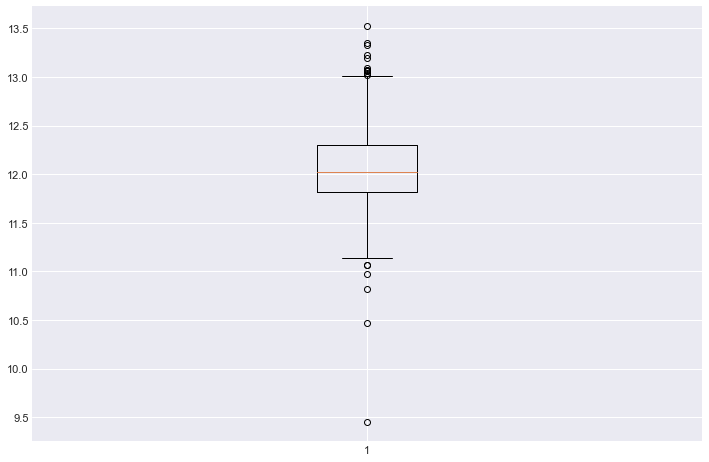

In [87]:
with plt.style.context('seaborn-darkgrid'): 
    plt.boxplot(np.log(df2['target']))
plt.show()

`-` 9.5부근에 있는 target만 추가로 제거합니다

In [88]:
df2[df2.target == df2.target.min()]

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,First_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt,target
1176,2,832,2,2,780,2,678,832,1,1,1923,1970,1928,12789


In [89]:
df2 = df2.drop(df2[df2.target == df2.target.min()].index).reset_index().drop('index', axis = 1)

## 파생변수 생성

`-` 주어진 변수를 활용하여 파생 변수를 만들겠습니다

`-` 퀄리티 관련 변수들을 그냥 더하여 새로운 파생변수를 만들 수 있습니다

`-` 하지만 퀄리티라고 해도 부엌의 퀄리티와 외관 재료의 퀄리티가 다를 수 있습니다(우선순위의 차이)

`-` 그러므로 간단히 랜덤포레스트를 사용해 피쳐 중요도에 따라 다른 가중치를 두어 합치겠습니다

`-` 화장실의 개수도 화장실의 퀄리티이며 차고에 들어가는 차량의 개수도 차고의 퀄리티로 판단하겠습니다

`-` 또한 지상층면적, 차고면적, 지하실면적을 합친 전체 집의 면적과 완공 연도와 리모델링 연도의 차이도 새로운 변수로 만들겠습니다

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [36]:
dt_ = df2.copy()

In [37]:
target_ = dt_['target']
dt_ = dt_.iloc[:, :-1]

In [42]:
rf = RandomForestRegressor(random_state = 21, criterion = 'mae')
rf.fit(dt_, target_)

RandomForestRegressor(criterion='mae', random_state=21)

In [43]:
qual_ = dict(zip(rf.feature_names_in_, rf.feature_importances_))
qual_['Exter_Qual'], qual_['Garage_Cars'], qual_['Kitchen_Qual'], qual_['Bsmt_Qual'], qual_['Full_Bath']

(0.007504524758655046,
 0.009590860727892673,
 0.011825757380935501,
 0.01754556041771484,
 0.06647633685016144)

`-` 피쳐 중요도는 Garage_Cars < Exter_Qual < Kitchen_Qual < Bsmt_Qual < Full_Bath 입니다

`-` 적당히 가중치를 주어 합치겠습니다

In [44]:
def feature_engineering(df_):
    df = df_.copy()
    df['Year_Gap_Remod'] = df['Year_Remod_Add'] - df['Year_Built'] ## 완공을 하고 몇 년뒤에 리모델링을 했는지를 나타낸다
    df['Total_SF'] = df['Gr_Liv_Area'] + df['Garage_Area'] + df['Total_Bsmt_SF'] ## 전체 집의 면적
    df['House_Qual'] = df['Exter_Qual']*0.1 + df['Garage_Cars']*0.1 + df['Kitchen_Qual']*0.2 + df['Bsmt_Qual']*0.2 + df['Full_Bath']*0.3 ## 퀄리티 변수들의 가중합
    
    df.drop(['Year_Remod_Add', 'Garage_Cars', 'Garage_Yr_Blt'] , axis = 1, inplace = True) ## 사용하지 않을 변수 제거
    
    ## Garage_Cars와 Garage_Area의 상관계수가 높아 Garage_Cars 피쳐를 드랍(Garage_Yr_Blt와 Year_Remod_Add도 마찬가지)
    ## Total_Bsmt_SF와 First_Flr_SF의 상관계수도 높아 둘 중 하나를 드랍해야 되지만 깜빡했다
    
    return df

### 교호작용 추가

`-` target(집값)을 예측하는데 있어 매우 중요한 변수는 Overall_Qual과 Total_SF 입니다

`-` Overall_Qual의 등급이 높으면 집값이 비싸고 Total_SF도 마찬가지로 값이 크면 집값이 비싸지죠

`-` 그런데 저는 동일하게 Total_SF(집의 면적)을 추가하더라도 Overall_Qual(전반적 재료 품질)에 따라 target(집값)의 상승폭이 다르다고 생각했습니다

`-` 즉 Overall_Qual이 4일 때 Total_SF를 1000 추가해서 집값이 5만 달러가 더 올랐다면

`-` Overall_Qual이 9일 때 Total_SF를 1000 추가해도 동일하게 집값이 5만 달러가 더 오르는가?

`-` 이 둘이 다르다면 Overall_Qual과 Total_SF간에 교호작용이 존재한다고 볼 수 있을 것입니다

In [45]:
df2 = feature_engineering(df2)

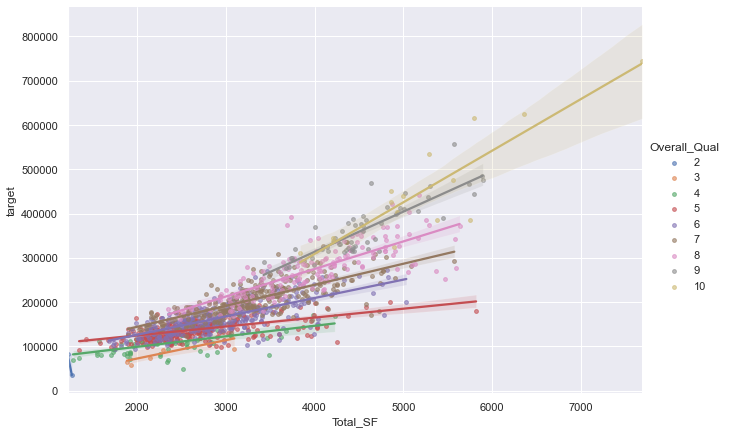

In [46]:
sns.lmplot(x = 'Total_SF', y = 'target', data = df2, hue = 'Overall_Qual', scatter_kws = {'alpha':0.6, 's':15}, height = 6, aspect = 1.5)

`-` Overall_Qual이 2와 3인 경우는 표본이 매우 적어서 무시하고 본다면

`-` Overall_Qual이 클수록 Total_SF이 똑같이 추가되도 target의 상승폭이 더 큽니다(기울기가 더 가파르다)

`-` Overall_Qual과 Total_SF간의 교호작용만 추가하기 아쉬워서 다른 피쳐간의 교호작용도 추가했지만 별로 유용하지는 않았습니다

In [47]:
def add_interaction(df_):
    df = df_.copy()
    
    df['Overall_Qual_Total_SF'] = df['Overall_Qual'] * df['Total_SF'] ## 전반적인 재료 퀄리티와 집의 전체 면적을 곱한다  
    df['Kitchen_Qual_First_Flr_SF'] = df['Kitchen_Qual'] * df['First_Flr_SF'] ## 부엌의 퀄리티와 1층 면적을 곱한다(1층에 부엌이 있을 것)
    df['Bath_Qual_First_Flr_SF'] = df['Full_Bath'] * df['First_Flr_SF'] ## 화장실 개수와 1층 면적을 곱한다(1층에 화장실이 있을 것)
    df['Bsmt_Qual_Total_Bsmt_SF'] = df['Bsmt_Qual'] * df['Total_Bsmt_SF'] ## 지하실 높이 수준과 지하실 면적을 곱한다

    return df

In [48]:
df2 = add_interaction(df2)

## 모델링

In [98]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer

In [50]:
dt = df2.copy()
log_target = np.log(dt['target'])
dt.drop('target', axis = 1, inplace = True)

In [51]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

In [52]:
def my_custom_loss_func(true, pred):
    return NMAE(np.exp(true), np.exp(pred)) 

In [53]:
score = make_scorer(my_custom_loss_func, greater_is_better = False)
kfold = KFold(n_splits = 5, random_state = 22, shuffle = True)

In [96]:
rf = RandomForestRegressor(random_state = 22, criterion = 'mae')
gb = GradientBoostingRegressor(random_state = 22, n_estimators = 350, learning_rate = 0.03, max_depth = 4, criterion = 'mae')
cb = CatBoostRegressor(random_state = 22, learning_rate = 0.03, n_estimators = 3000, depth = 4, loss_function = 'MAE', verbose = 0)
xgb = XGBRegressor(random_state = 22, n_estimators = 500,  max_depth = 4, learning_rate = 0.03, min_child_weight = 2) 
lgb = LGBMRegressor(random_state = 22, n_estimators = 400, max_depth = 4, learning_rate = 0.03, num_leaves = 9)

In [97]:
for model in ['rf', 'gb', 'cb', 'xgb', 'lgb']:
    scores = cross_validate(eval(model), dt, log_target, scoring = score, cv = kfold)
    print('------------------------------------ ' + str(model) + ' ------------------------------------')
    print('교차 검증별 NMAE: ', abs(scores['test_score']))
    print('교차 검증 NMAE 평균: ', np.mean(abs(scores['test_score'])))
    print('교차 검증 NMAE 표준편차: ', np.std(abs(scores['test_score'])))

------------------------------------ rf ------------------------------------
교차 검증별 NMAE:  [0.09439534 0.08549849 0.09282394 0.09797326 0.09807528]
교차 검증 NMAE 평균:  0.09375325945952193
교차 검증 NMAE 표준편차:  0.0046022912256350485
------------------------------------ gb ------------------------------------
교차 검증별 NMAE:  [0.08957008 0.08521185 0.09017076 0.09245771 0.10034929]
교차 검증 NMAE 평균:  0.09155193725372882
교차 검증 NMAE 표준편차:  0.00498489512654774
------------------------------------ cb ------------------------------------
교차 검증별 NMAE:  [0.0832666  0.0886138  0.08945756 0.08734808 0.09642484]
교차 검증 NMAE 평균:  0.0890221762905821
교차 검증 NMAE 표준편차:  0.004268136815129975
------------------------------------ xgb ------------------------------------
교차 검증별 NMAE:  [0.08778014 0.08481836 0.08825539 0.090204   0.09938245]
교차 검증 NMAE 평균:  0.09008806867902328
교차 검증 NMAE 표준편차:  0.004956895862959923
------------------------------------ lgb ------------------------------------
교차 검증별 NMAE:  [0.09024129 0.08

## test 예측

In [55]:
test2 = feature_engineering(test)
test2 = add_interaction(test2)

`-` 교차 검증 MNAE의 평균이 가장 높은 랜덤포레스트는 제외하고 앙상블을 합니다

In [56]:
gb.fit(dt, log_target)
xgb.fit(dt, log_target, verbose = 0)
lgb.fit(dt, log_target, verbose = 0)
cb.fit(dt, log_target)

gb_pred = np.exp(gb.predict(test2))
lgb_pred = np.exp(lgb.predict(test2))
xgb_pred = np.exp(xgb.predict(test2))
cb_pred = np.exp(cb.predict(test2))

pred = (gb_pred + xgb_pred + lgb_pred + cb_pred) / 4

In [57]:
submission = pd.read_csv('sample_submission.csv')

In [58]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = pred

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,334315.200367
1,2,128436.762671
2,3,172754.055755
3,4,249590.993957
4,5,135889.842890


In [59]:
## submission을 csv 파일로 저장
submission.to_csv('submission.csv', index = False)